In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

### Load data

In [3]:
# Load data
train = pd.read_csv('../../data/processed/train_esg_shortened.csv')
test = pd.read_csv('../../data/processed/test_esg_shortened.csv')

In [4]:
train

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level
0,A,2022,1,thank emily welcome everyone agilents conferen...,15.0,Low
1,A,2022,3,thank hannah welcome everyone agilents confere...,15.0,Low
2,AAPL,2022,1,good day welcome apple q fy earnings conferenc...,17.0,Low
3,AAPL,2022,2,good day welcome apple q fy earnings conferenc...,17.0,Low
4,AAPL,2022,3,good day welcome apple q fy earnings conferenc...,17.0,Low
...,...,...,...,...,...,...
542,WMT,2023,3,followed questionandanswer session turn call d...,25.0,Medium
543,YUM,2022,1,welcome q yum brand earnings conference call n...,21.0,Medium
544,YUM,2022,2,get started would like remind conference call ...,21.0,Medium
545,ZTS,2022,1,thank operator good morning everyone welcome z...,18.0,Low


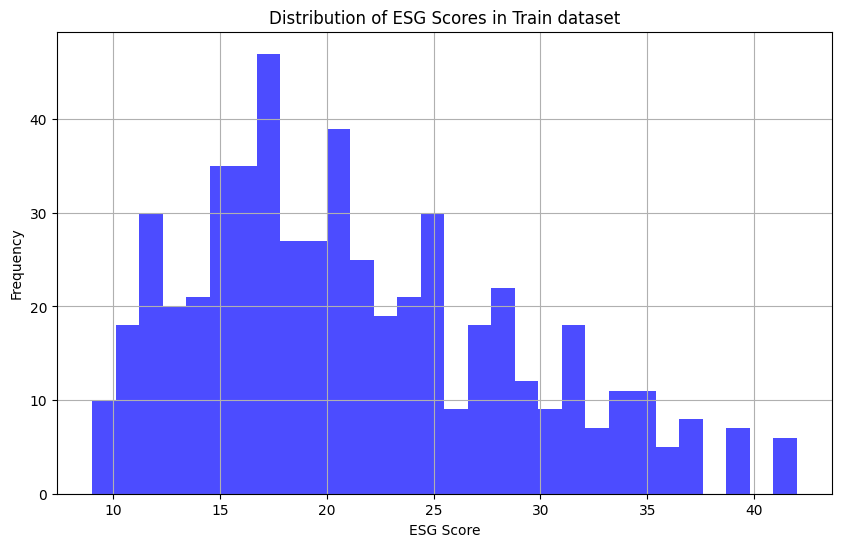

In [5]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'esg_score'
plt.figure(figsize=(10, 6))
plt.hist(train['esg_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ESG Scores in Train dataset')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

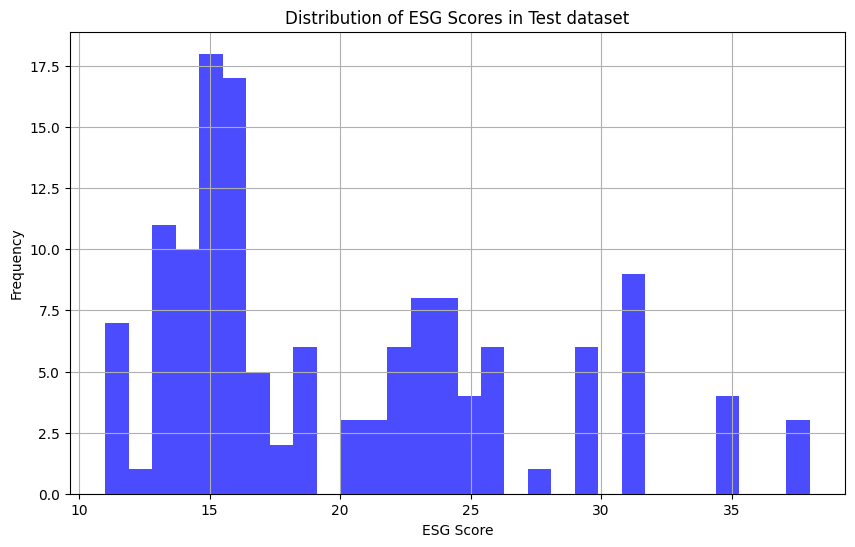

In [6]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'esg_score'
plt.figure(figsize=(10, 6))
plt.hist(test['esg_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ESG Scores in Test dataset')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

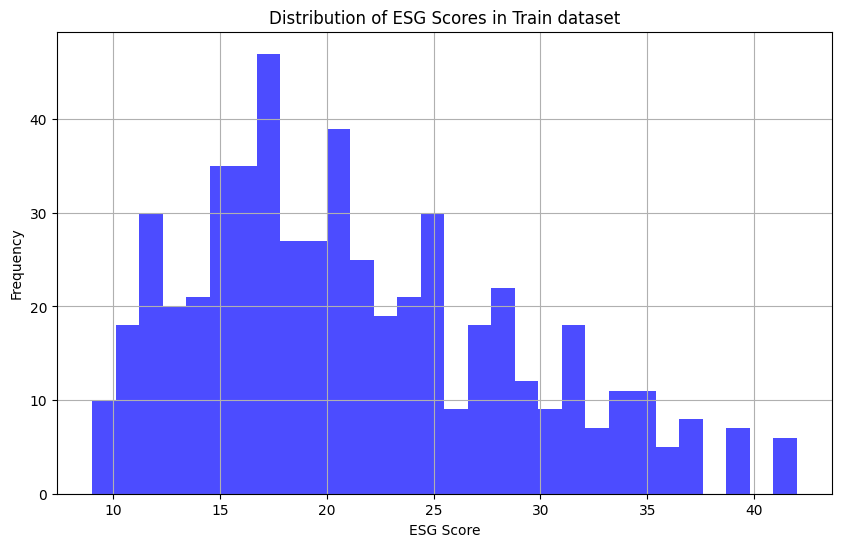

In [7]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'esg_score'
plt.figure(figsize=(10, 6))
plt.hist(train['esg_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ESG Scores in Train dataset')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [64]:
# Assuming esg_score is categorical, if not, this section needs to be adjusted for regression
train['esg_score'] = train['esg_score'].astype(int)  # Ensure esg_score is integer if it's categorical
test['esg_score'] = test['esg_score'].astype(int)

### Load Tokenizer and Encode Text

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('nbroad/ESG-BERT')

def encode_texts(texts):
    # Ensure all texts are strings and handle any potential None or NaN values
    texts = [str(text) if text is not None else "" for text in texts]
    # Use the tokenizer on the cleaned list of texts
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

c:\Users\User\anaconda3\envs\FINA4350\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--nbroad--ESG-BERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
# Encode and handle labels
train_encodings = encode_texts(train['transcript_esg'].tolist())
test_encodings = encode_texts(test['transcript_esg'].tolist())

### Define Dataset class

In [10]:
# Dataset class
class ESGDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)  # Use float for regression

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


In [11]:
# Create dataset  
train_dataset = ESGDataset(train_encodings, train['esg_score'].tolist())
test_dataset = ESGDataset(test_encodings, test['esg_score'].tolist())

### Prepare Model 

In [12]:
model = BertForSequenceClassification.from_pretrained('nbroad/ESG-BERT')

# For regression, we need to remove the classification head that outputs logits for classes
model.classifier = torch.nn.Linear(model.config.hidden_size, 1)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()  # Use MSELoss for regression

config.json:   0%|          | 0.00/2.67k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

c:\Users\User\anaconda3\envs\FINA4350\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Move model to device
device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Training Loop

In [71]:
# from torch.utils.data import WeightedRandomSampler

# # Create a weighted sampler

# # Calculate sample weights based on the inverse frequency of the esg_scores
# score_counts = train['esg_score'].value_counts()
# score_weights = len(train) / (score_counts * len(score_counts))
# train['sample_weight'] = train['esg_score'].map(score_weights)

# # Convert sample weights to a tensor
# sample_weights_tensor = torch.tensor(train['sample_weight'].values, dtype=torch.float)

# weighted_sampler = WeightedRandomSampler(
#     weights=sample_weights_tensor,
#     num_samples=len(sample_weights_tensor),
#     replacement=True
# )

# # Create your DataLoader with the sampler
# train_loader = DataLoader(train_dataset, batch_size=16, sampler=weighted_sampler)

In [73]:
# # Training loop
# model.train()
# for epoch in range(3):
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device).unsqueeze(1)  # Add an extra dimension to labels

#         outputs = model(input_ids, attention_mask=attention_mask)
#         loss = criterion(outputs.logits, labels)  # Do not convert logits to float for MSE loss
        
#         loss.backward()
#         optimizer.step()


Epoch 3: 100%|██████████| 35/35 [12:21<00:00, 21.18s/it]


### Evaluation 

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define the evaluation function
def evaluate_model(model, dataset, criterion, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=16)
    predictions = []
    actuals = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Collect actual and predicted values for metrics
            predictions.extend(outputs.logits.squeeze().tolist())
            actuals.extend(labels.squeeze().tolist())

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    return mse, mae, predictions, actuals

# Evaluate the model
mse, mae, predictions, actuals = evaluate_model(model, test_dataset, criterion, device)

# Output the MSE and MAE
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

MSE: 452.5554443719074
MAE: 20.13353027343966


In [16]:
# Save the results to a CSV file
test['predicted_esg_score'] = predictions
results_csv_path = '../../data/predicted/vanilla_ESG_Bert_score_predicted_results.csv'
test.to_csv(results_csv_path, index=False)

# Provide the path to the saved CSV file
results_csv_path

'../../data/predicted/vanilla_ESG_Bert_score_predicted_results.csv'

### Original function, abanadoned
```
def evaluate(model, dataset, criterion, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=16)
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)  # Add an extra dimension to labels

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Do not convert logits to float for MSE loss
            total_loss += loss.item()

    return total_loss / len(loader)
```

In [75]:
# train_loss = evaluate(model, train_dataset, criterion, device)
# test_loss = evaluate(model, test_dataset, criterion, device)
# print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")

Train Loss: 81.96169256482806, Test Loss: 61.21079428990682
